In [10]:
# !pip install --upgrade albumentations -q


import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFile
import glob
import shutil
import cv2

from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image  

import albumentations as A
from tensorflow.keras.models import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model

In [11]:
def draw_plot_from_history(history, metric, n_epochs, stage):
    plt.style.use("ggplot")
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(0, n_epochs), history.history[metric], label="train_%s" % metric)
    if "val_%s" % metric in history.history:
        plt.plot(np.arange(0, n_epochs), history.history["val_%s" % metric], label="val_%s" % metric)
    title = stage + '_%s' % metric
    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Value")
    plt.legend()
    filename = title + '.png'
    plt.show()

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, augmentation, image_size, shuffle=True):
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.image_size = image_size

        self.image_names = np.array([item['path'] for item in data])
        self.targets = to_categorical(np.array([int(item['label'][1:]) for item in data]))
        self.samples = len(self.targets)

        self.indexes = np.arange(self.samples)
        if shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def transform_image(self, image):
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation = cv2.INTER_CUBIC)

        if self.augmentation:
            image = self.augmentation(image=image)['image']

        return image

    def __getitem__(self, index):
        take_ind = self.indexes[index * self.batch_size: min((index + 1) * self.batch_size, len(self.targets))]
        X = np.empty((len(take_ind), self.image_size, self.image_size, 3))
        y = self.targets[take_ind, :]

        for i in range(len(take_ind)):
            img = cv2.imread(self.image_names[take_ind[i]], cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.transform_image(img)
            X[i] = img

        return X, y

Create augmentations:

In [13]:
transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, 
                           p=0.5, border_mode=cv2.BORDER_CONSTANT), 
        A.RandomBrightnessContrast(p=0.5),
        A.RGBShift(p=0.25),
        A.GaussNoise(p=0.25),
        A.HorizontalFlip(p=0.5),
    ]
)

Create generators:

In [14]:
TRAIN_DIR = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
TEST_DIR = "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"

In [15]:
INPUT_SHAPE = 224
BATCH_SIZE = 32
num_classes = 10

In [16]:
train_data = []
label_stat = []

for label in os.listdir(TRAIN_DIR):
    for img_path in glob.glob(os.path.join(TRAIN_DIR, label, "*.jpg")):
        train_data.append({'path': img_path, 'label': label})
        label_stat.append(label)

train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=label_stat, shuffle=True)

train_generator = DataGenerator(train_data, BATCH_SIZE, transform, INPUT_SHAPE)
validation_generator = DataGenerator(val_data, BATCH_SIZE, None, INPUT_SHAPE, shuffle=False)

Build model:

In [17]:
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(INPUT_SHAPE, INPUT_SHAPE, 3))

for layer in model.layers:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

16711680/16705208 [==============================] - 0s 0us/step


Warmup:

In [18]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.001

Epoch 1/3
560/560 [==============================] - 312s 546ms/step - loss: 1.8181 - accuracy: 0.4011 - val_loss: 0.8767 - val_accuracy: 0.8275
Epoch 2/3
560/560 [==============================] - 195s 349ms/step - loss: 0.9715 - accuracy: 0.7292 - val_loss: 0.6223 - val_accuracy: 0.8643
Epoch 3/3
560/560 [==============================] - 199s 355ms/step - loss: 0.7821 - accuracy: 0.7767 - val_loss: 0.5003 - val_accuracy: 0.8904


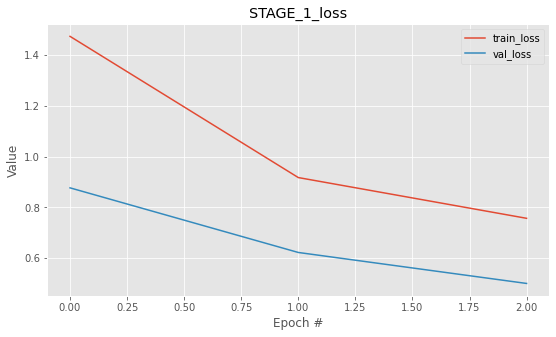

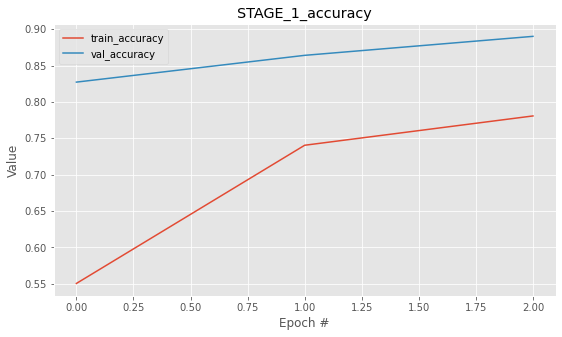

In [19]:
opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS, verbose=1)

draw_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_1')
draw_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_1')

In [20]:
model.save("model2_stage1.hdf5")

Unfreezeing deeper layers:

In [25]:
NUM_EPOCHS = 15
LEARNING_RATE = 0.0003
FINE_TUNE_FROM_LAYER = -20

In [26]:
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[FINE_TUNE_FROM_LAYER:]:
    if not isinstance(layer, tensorflow.keras.layers.BatchNormalization):
        layer.trainable = True

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
560/560 [==============================] - 206s 359ms/step - loss: 0.4774 - accuracy: 0.8452 - val_loss: 0.0809 - val_accuracy: 0.9779

Epoch 00001: val_loss improved from inf to 0.08092, saving model to model2_stage2.hdf5
Epoch 2/15
560/560 [==============================] - 202s 361ms/step - loss: 0.1606 - accuracy: 0.9498 - val_loss: 0.0465 - val_accuracy: 0.9875

Epoch 00002: val_loss improved from 0.08092 to 0.04653, saving model to model2_stage2.hdf5
Epoch 3/15
560/560 [==============================] - 201s 360ms/step - loss: 0.1022 - accuracy: 0.9681 - val_loss: 0.0352 - val_accuracy: 0.9900

Epoch 00003: val_loss improved from 0.04653 to 0.03519, saving model to model2_stage2.hdf5
Epoch 4/15
560/560 [==============================] - 200s 357ms/step - loss: 0.0791 - accuracy: 0.9752 - val_loss: 0.0336 - val_accuracy: 0.9891

Epoch 00004: val_loss improved from 0.03519 to 0.03360, saving model to model2_stage2.hdf5
Epoch 5/15
560/560 [==============================] 

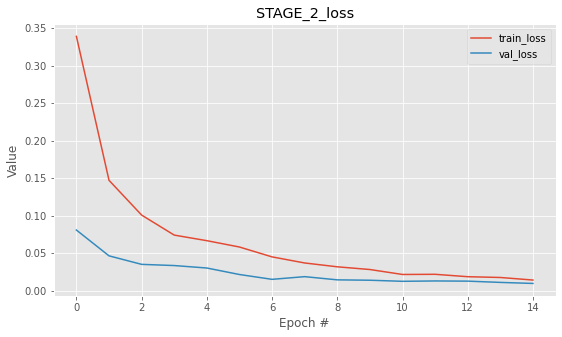

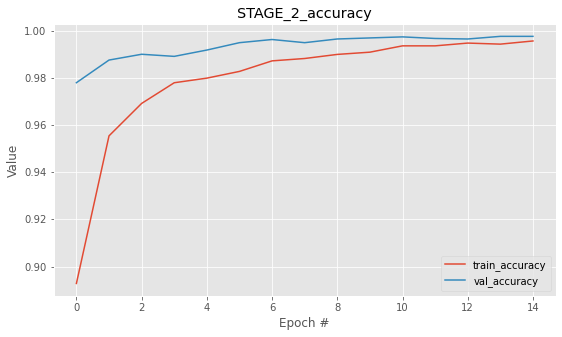

In [27]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=NUM_EPOCHS * train_generator.samples // BATCH_SIZE,
    end_learning_rate=LEARNING_RATE / 10,
    power=1.0)

opt = Adam(learning_rate=learning_rate_fn)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

save_best_checkpoint = ModelCheckpoint("model2_stage2.hdf5", verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    callbacks=[save_best_checkpoint], 
    verbose=1)

draw_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_2')
draw_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_2')

In [28]:
def save_plot_from_history(history, metric, n_epochs, stage):
    plt.style.use("ggplot")
    plt.figure(figsize=(21, 15))
    plt.plot(np.arange(0, n_epochs), history.history[metric], label="train_%s" % metric)
    if "val_%s" % metric in history.history:
        plt.plot(np.arange(0, n_epochs), history.history["val_%s" % metric], label="val_%s" % metric)
    title = metric
    plt.title(title, fontsize=18)
    plt.xlabel("Epoch #", fontsize=18)
    plt.ylabel("Value", fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    filename = title + '.png'
    plt.savefig(filename)

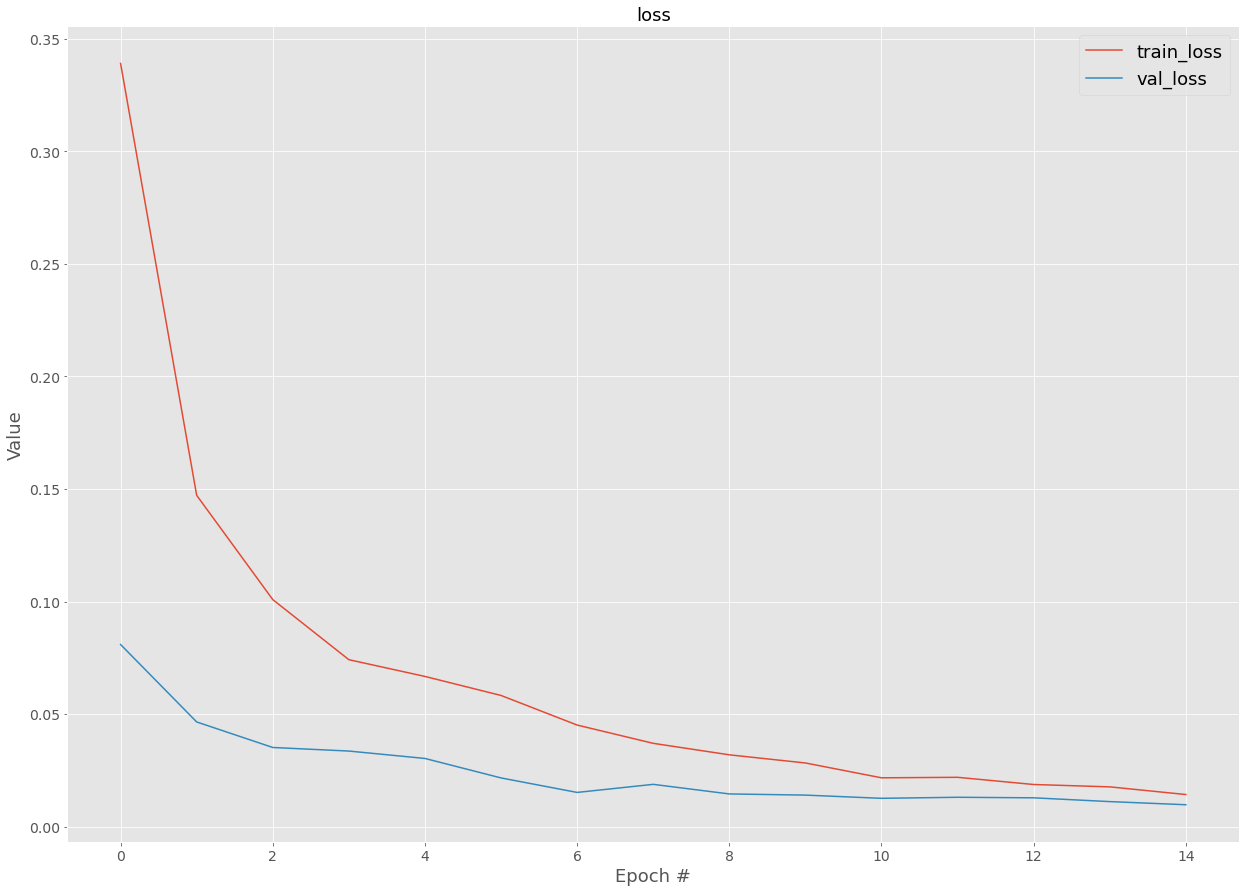

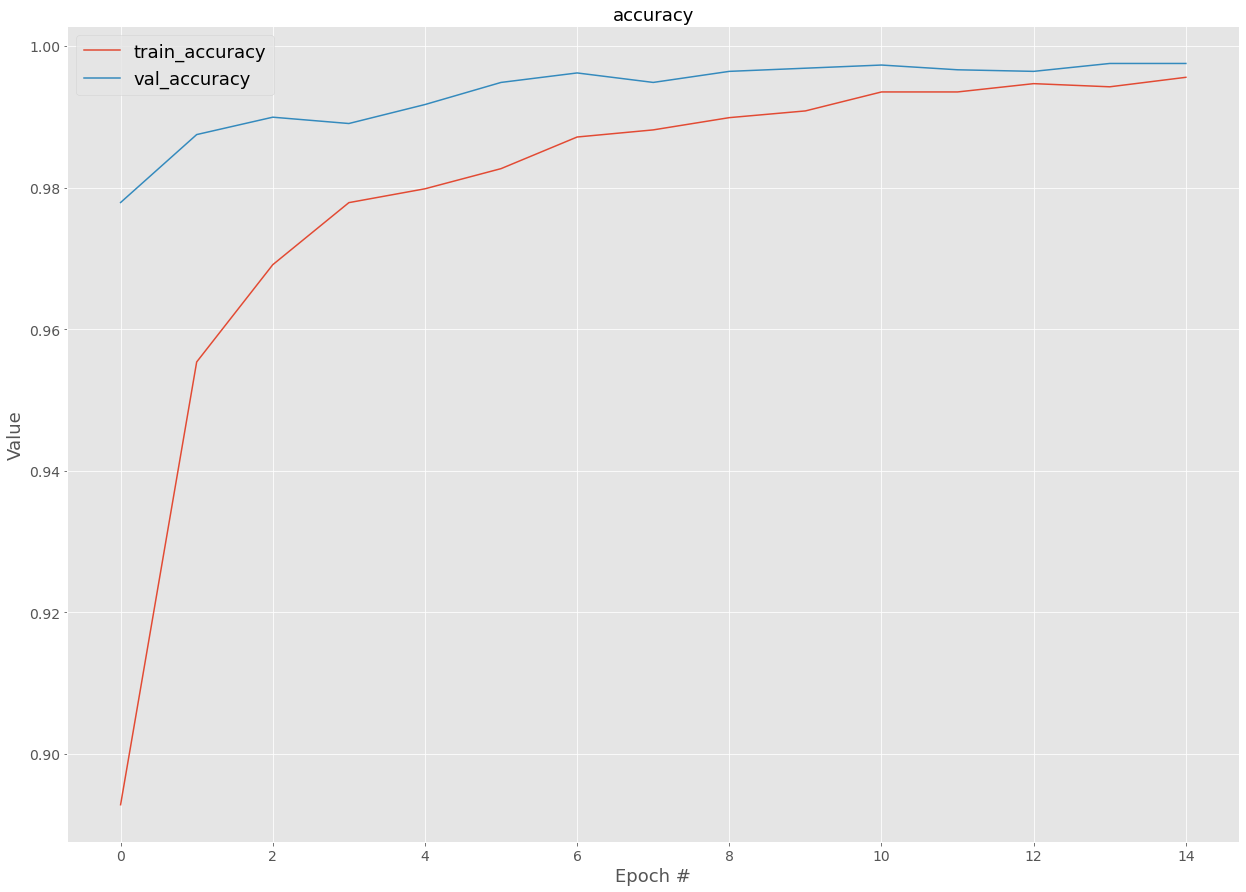

In [29]:
save_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_2')
save_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_2')

Make predictions:

In [30]:
from tqdm.auto import tqdm

In [31]:
def classify(model, test_img_dir):

    result = dict()
    keys = ['name', *['c%d' % i for i in range(10)]]
    for key in keys:
        result[key] = []
        
    paths = sorted(list(os.listdir(test_img_dir)))

    for path in tqdm(paths):
        if not path.endswith('.jpg'):
            continue
        
        image = cv2.imread(os.path.join(test_img_dir, path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), interpolation = cv2.INTER_CUBIC)

        pred = model.predict(np.expand_dims(image, 0))[0]
        result['name'].append(path)
        for i in range(10):
            result['c%d' % i].append(pred[i])

    return result

In [32]:
model = load_model('model2_stage2.hdf5')

In [33]:
result = classify(model, TEST_DIR)

  0%|          | 0/79726 [00:00<?, ?it/s]

In [34]:
dct = {'img': result['name']}
for i in range(10):
    col = 'c%d' % i
    dct[col] = result[col]
    
df = pd.DataFrame(dct)
df.to_csv('submission.csv', index=False)
df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,4.068254e-08,4.582623e-10,1.378505e-08,4.692738e-06,5.291642e-08,9.518389e-01,5.725163e-09,1.531482e-07,5.745339e-06,4.815060e-02
1,img_10.jpg,1.854153e-02,6.463598e-10,2.595318e-07,1.948244e-08,2.379751e-04,9.812114e-01,3.816984e-06,5.418246e-09,4.873493e-06,3.718787e-08
2,img_100.jpg,9.846959e-01,5.868878e-07,3.061289e-07,2.007378e-05,2.288758e-07,4.336547e-06,1.911325e-03,5.652663e-07,3.091607e-03,1.027509e-02
3,img_1000.jpg,5.703976e-10,1.273074e-09,6.271677e-03,9.298731e-13,8.729962e-11,3.744163e-10,1.064557e-05,5.405752e-07,9.936417e-01,7.549996e-05
4,img_100000.jpg,7.663979e-11,1.000274e-15,2.617494e-14,9.999998e-01,2.528084e-07,2.655542e-10,8.918793e-13,1.016876e-14,8.215380e-12,6.711057e-12
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,8.123158e-07,9.996718e-01,2.546038e-04,1.979160e-07,6.970713e-10,7.913213e-09,1.522641e-05,2.727795e-05,1.291183e-05,1.717176e-05
79722,img_99995.jpg,2.587324e-06,1.471372e-05,1.233328e-10,9.999511e-01,1.186666e-07,4.580854e-08,3.759195e-06,3.961207e-09,3.741839e-07,2.728370e-05
79723,img_99996.jpg,1.559457e-04,7.419074e-02,1.880176e-06,9.179580e-01,7.406871e-03,8.514086e-07,3.871996e-06,2.170226e-05,2.411183e-04,1.895405e-05
79724,img_99998.jpg,4.425149e-16,5.025418e-16,2.421635e-08,8.410035e-21,2.711529e-15,3.249531e-18,9.999998e-01,1.678393e-16,2.478026e-07,1.213000e-14


Improve score a bit with clipping hack:

In [ ]:
df_new = df.copy()

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
arr, names = df_new.values[:, 1:], df_new.values[:, 0]
arr = np.clip(arr, 0.025, 0.975)
arr /= np.sum(arr, axis=1, keepdims=True)

new_df = pd.DataFrame(np.hstack([names.reshape((-1, 1)), arr]), columns=df.columns)
new_df.to_csv('submission_new.csv', index=False)